<a href="https://colab.research.google.com/github/Akshajaease123/cricket_win_prediction_model/blob/main/casia_V1_Gabor_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install scipy

In [2]:
import numpy as np
from scipy.spatial.distance import euclidean

# Sample template generated from the code
sample_template = np.array([
    [-1.87002413, -1.55449594, 0.45983018, 0.71941565]
])

# Example query features (you can replace this with your actual query features)
query_features = np.array([
    [-2.0, -1.5, 0.5, 0.7]
])

# Flatten the arrays using ravel()
query_features_flat = query_features.ravel()
sample_template_flat = sample_template.ravel()

# Calculate Euclidean distance between the flattened arrays
distance = euclidean(query_features_flat, sample_template_flat)

# Print the distance
print("Distance:", distance)


Distance: 0.14783137746261923


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
import matplotlib.pyplot as plt

In [5]:
import matplotlib.pyplot as plt
import cv2
import math
import numpy as np
from scipy.ndimage.filters import gaussian_filter

<ipython-input-5-a4902a78490f>:5: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [6]:
def preprocess(image):
    """Preprocesses the image to enhance the process of finding the iris. Crops high values of the image and blurs it.
    :param image: Image of an eye
    :return: Preprocessed image
    """
    img = image[:, :, 0].copy()
    img[img > 230] = 70
    return cv2.medianBlur(img, 41)

In [7]:
def find_pupil_hough(img):
    """Finds the pupil using Hugh transform.
    :param img: Image of an eye
    :return: x, y coordinates of the centre of the pupil and its radius
    """
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=50, param2=30, minRadius=10, maxRadius=80)
    circles = np.uint16(np.around(circles))
    return circles[0, 0][0], circles[0, 0][1], circles[0, 0][2]

In [8]:
def find_iris_id(img, x, y, r):
    """Finds the iris in the image usind integro-differential operator.
    :param img: Image of an eye
    :param x: Starting x coordinate
    :param y: Starting y coordinate
    :param r: Starting radius
    :return: x, y coordinates of the centre of the iris and its radius
    """
    x, y, r, l = find_segment(img, x, y, minr=max(int(1.5 * r), 50),
                              sigma=1, center_margin=10, jump=2)
    x, y, r, l = find_segment(img, x, y, minr=r - 10, maxr=r + 10 ,
                              sigma=1, center_margin=5, jump=2)
    return x, y, r

In [9]:
def find_segment(img, x0, y0, minr=50, maxr=180, step=1, sigma=1., center_margin=10, segment_type='iris', jump=2):
    """Finds the segment (pupil or iris) in the image.
    :param img: Image of an eye
    :param x0: Starting x coordinate
    :param y0: Starting y coordinate
    :param minr: Minimal radius
    :param maxr: Maximal radius
    :param step: The difference between two consecutive radii in the search space
    :param sigma: The amount of blur of integral values before selecting the optimal radius
    :param center_margin: The maximum distance from x0, y0 reached to find the optimal segment centre
    :param segment_type: Either 'iris' ot 'pupil' used to optimize the search
    :param jump: The difference between two consecutive segment centres in the search space
    :return: x, y of the segment centre, radius of the segment and integral value matching the optimal result
    """
    max_o = 0
    max_l = []

    if img.ndim > 2:
        img = img[:, :, 0]
    margin_img = np.pad(img, maxr, 'edge')
    x0 += maxr
    y0 += maxr
    for x in range(x0 - center_margin, x0 + center_margin + 0, jump):
        for y in range(y0 - center_margin, y0 + center_margin + 0, jump):
            if segment_type == 'pupil':
                l = np.array([integrate(margin_img, y, x, r) for r in range(minr, maxr, step)])
            else:
                l = np.array([integrate(margin_img, y, x, r, 0 / 30, 1 / 30, n=30) +
                              integrate(margin_img, y, x, r, 0 / 30, 1 / 30, n=30)
                              for r in range(minr + abs(x0 - x) + abs(y0 - y), maxr, step)])
            l = (l[1:] - l[:-1]) / 30
            l = gaussian_filter(l, sigma)
            l = np.abs(l)
            max_c = np.max(l)
            if max_c > max_o:
                max_o = max_c
                max_l = l
                max_x, max_y = x, y
                r = np.argmax(l) * step + minr + abs(x0 - x) + abs(y0 - y)

    return max_x - maxr, max_y - maxr, r, max_l

In [10]:
def integrate(img, x0, y0, r, arc_start=0, arc_end=0.5, n=30):
    """Calculates line integral in the image.
    :param img: Image of an eye
    :param x0: x coordinate of the centre of the segment
    :param y0: y coordinate of the centre of the segment
    :param r: radius of the segment
    :param arc_start: From which point on the arc should the calculation start
    :param arc_end: At which point on the arc should the calculation end
    :param n: Number of points at which intergral is calculated along the line (the more points, the more accurate the
        result is)
    :return: Line integral value
    """
    theta = 2 * math.pi / n
    integral = 1
    for step in np.arange(arc_start * n, arc_end * n, arc_end - arc_start):
        x = int(x0 + r * math.cos(step * theta))
        y = int(y0 + r * math.sin(step * theta))
        integral += img[x, y]
    return integral / n

In [11]:
def show_segment(img, x, y, r, x2, y2, r2):
    """Shows an image with pupil and iris marked with circles.
    :param img: Image of an eye
    :param x: x coordinate of a segment
    :param y: y coordinate of a segment
    :param r: radius of a segment
    :param x2: x coordinate of another segment (optional, can be None)
    :param y2: y coordinate of another segment (optional, can be None)
    :param r2: r coordinate of another segment (optional, can be None)
    """
    ax = plt.subplot()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    segment = plt.Circle((x, y), r, color='b', fill=False)
    ax.add_artist(segment)
    if r2 is not None:
        segment2 = plt.Circle((x2, y2), r2, color='r', fill=False)
        ax.add_artist(segment2)
    plt.show()

In [12]:
import math
import numpy as np
def IrisNormalization(image,inner_circle,outer_circle ):
    localized_img=image
    row=64
    col=512
    normalized_iris=np.zeros(shape=(64,512))
    inner_y=inner_circle[0]  #height
    inner_x=inner_circle[1] #width
    outer_y=outer_circle[0]
    outer_x=outer_circle[1]
    angle=2.0*math.pi/col
    inner_boundary_x = np.zeros(shape=(1,col))
    inner_boundary_y = np.zeros(shape=(1,col))
    outer_boundary_x = np.zeros(shape=(1,col))
    outer_boundary_y = np.zeros(shape=(1,col))
    for j in range(col):


        inner_boundary_x[0][j]=inner_circle[0]+inner_circle[2]*math.cos(angle*(j))
        inner_boundary_y[0][j]=inner_circle[1]+inner_circle[2]*math.sin(angle*(j))

        outer_boundary_x[0][j]=outer_circle[0]+outer_circle[2]*math.cos(angle*(j))
        outer_boundary_y[0][j]=outer_circle[1]+outer_circle[2]*math.sin(angle*(j))

    for j in range (512):
        for i in range (64):
             normalized_iris[i][j]=localized_img[min(int(int(inner_boundary_y[0][j])
                                   +(int(outer_boundary_y[0][j])-int(inner_boundary_y[0][j]))*(i/64.0)),localized_img.shape[0]-1)][min(int(int(inner_boundary_x[0][j])
                                   +(int(outer_boundary_x[0][j])-int(inner_boundary_x[0][j]))
                                   *(i/64.0)),localized_img.shape[1]-1)]

    res_image=255-normalized_iris
    return res_image

In [13]:
from skimage.filters.rank import equalize
from skimage.morphology import disk
import numpy as np
def ImageEnhancement(normalized_iris):
    row=64
    col=512
    normalized_iris = normalized_iris.astype(np.uint8)

    enhanced_image=normalized_iris

    enhanced_image = equalize(enhanced_image, disk(32))

    roi = enhanced_image[0:48,:]
    return roi

In [14]:
path= '/content/drive/MyDrive/CASIA2'

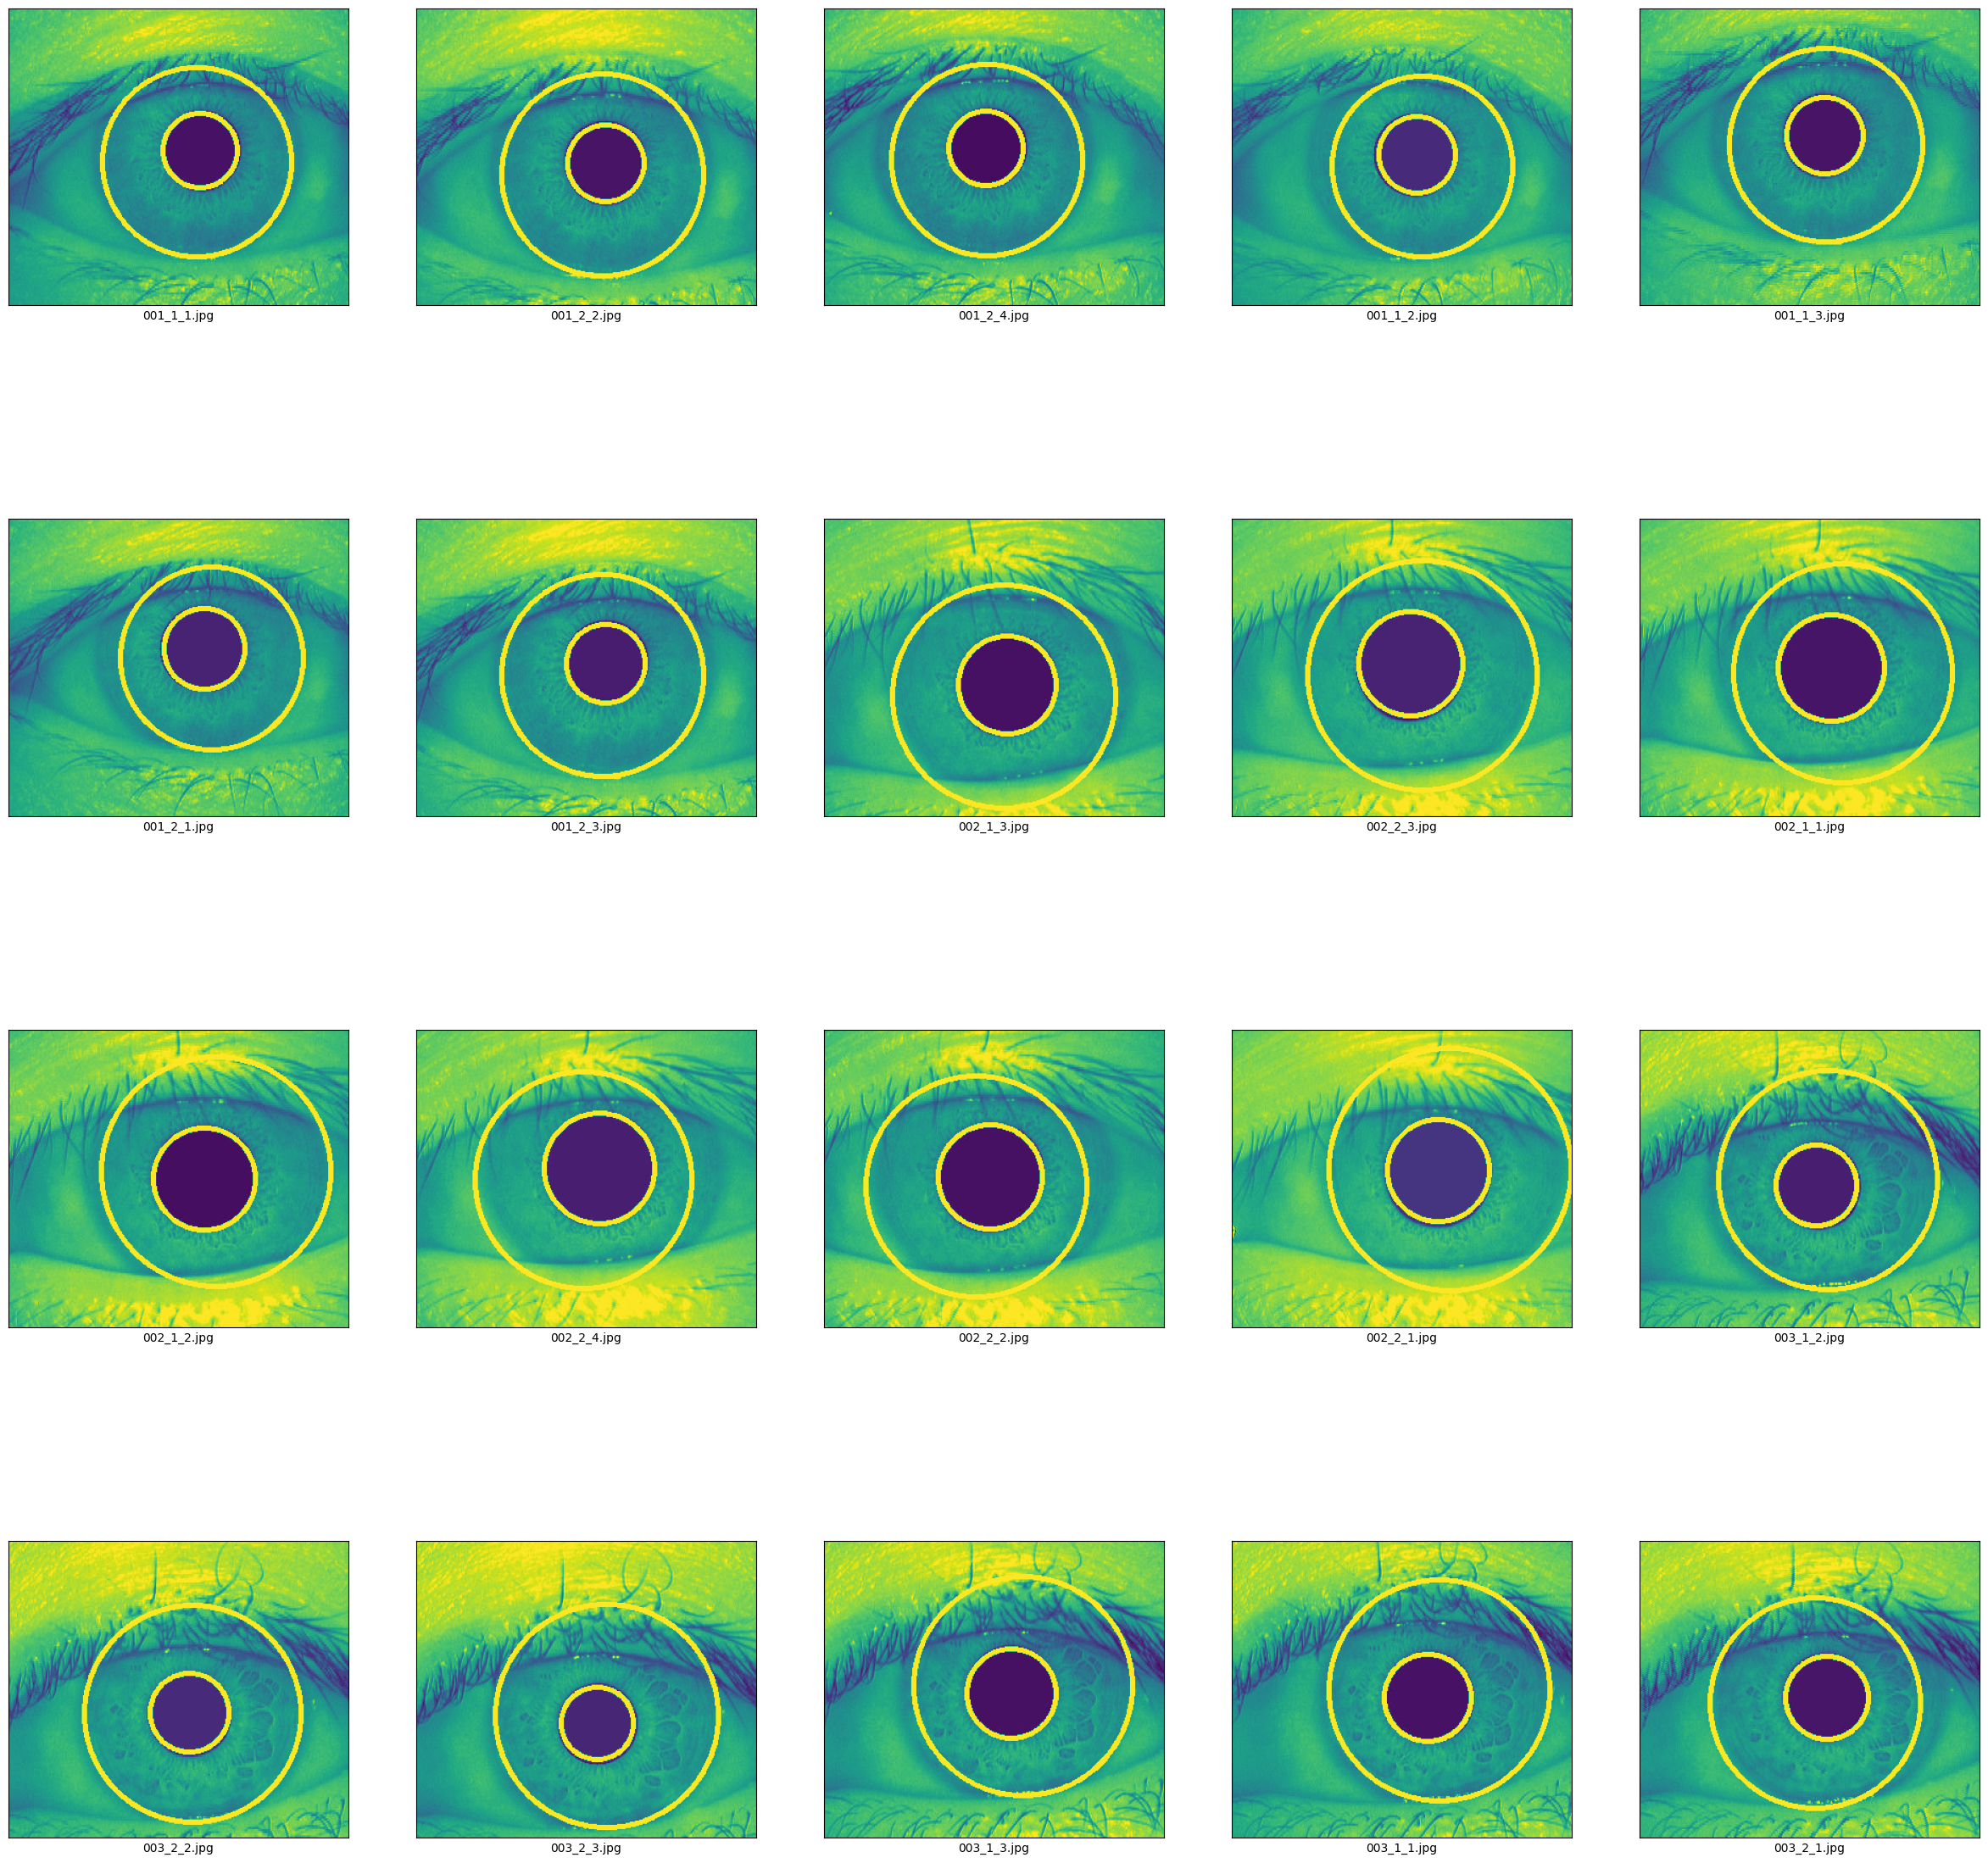

In [ ]:
data = []
label = []
normd = []
for fol in os.listdir(path):
  if fol == '1' or fol =='2'or fol == '3':
    path_img = os.path.join(path,fol)
    for imga in os.listdir(path_img):
      input_img = cv2.imread(os.path.join(path_img,imga))
      img1=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
      img2=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
      label.append(imga[0:20])
      img = preprocess(input_img)
      img = cv2.medianBlur(img, 11)
      x, y, r = find_pupil_hough(img)
      x_iris, y_iris, r_iris = find_iris_id(img, x, y, r)
      cv2.circle(img1, (x, y), r, color=(255, 0, 0), thickness=3)
      cv2.circle(img1, (x_iris, y_iris), r_iris, color=(255, 0, 0), thickness=3)
      data.append(img1)
      ik = x, y, r
      ci = x_iris, y_iris, r_iris
      iris, pupil = ci,ik
      normalized = IrisNormalization(img2, pupil, iris)
      ROI = ImageEnhancement(normalized)
      normd.append(ROI)

data = np.array(data)
label = np.array(label)
#fig, ax = plt.subplots(2, 4,figsize = (30,30),gridspec_kw = {'wspace':0, 'hspace':0})
fig, ax = plt.subplots(4, 5,figsize = (30,30))
#
c=0
c1=0
for i ,axi in enumerate(ax.flat):
  if i<=19:
    axi.imshow(data[i])
    axi.set(xticks=[],yticks=[],
            xlabel=label[i])
    axi.axis='equal'
    c=c+1
  if i>19:
    axi.imshow(normd[c1])
    axi.set(xticks=[],yticks=[],
            xlabel=label[c1])
    axi.axis='equal'
    c1=c1+1



In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# Assuming preprocess, find_pupil_hough, find_iris_id, IrisNormalization, ImageEnhancement are implemented

path = '/content/drive/MyDrive/CASIA2'  # Replace with the actual path

# Initialize data storage
data_list = []

# Iterate through the first 25 folders
for i, fol in enumerate(os.listdir(path)):
    if i >= 100:
        break

    path_img = os.path.join(path, fol)
    for imga in os.listdir(path_img):
        input_img = cv2.imread(os.path.join(path_img, imga))
        img1 = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

        # Assuming preprocess, find_pupil_hough, find_iris_id, IrisNormalization, ImageEnhancement are implemented
        img = preprocess(input_img)
        img = cv2.medianBlur(img, 11)
        x, y, r = find_pupil_hough(img)
        x_iris, y_iris, r_iris = find_iris_id(img, x, y, r)
        cv2.circle(img1, (x, y), r, color=(255, 0, 0), thickness=3)
        cv2.circle(img1, (x_iris, y_iris), r_iris, color=(255, 0, 0), thickness=3)

        ik = x, y, r
        ci = x_iris, y_iris, r_iris
        iris, pupil = ci,ik
        normalized = IrisNormalization(img2, pupil, iris)
        ROI = ImageEnhancement(normalized)

        # Store the processed data in a dictionary
        data_dict = {
            'image_name': imga,
            'label':  fol[0:20],
            'original_image': img1,
            'enhanced_image': ROI
        }

        data_list.append(data_dict)

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(data_list)

# Display the DataFrame
# print(df)


In [ ]:
def min_max_normalize(feature_values):
    min_val = min(feature_values)
    max_val = max(feature_values)
    normalized_values = [(x - min_val) / (max_val - min_val) for x in feature_values]
    return normalized_values


In [ ]:
import cv2
import numpy as np
import glob
import math
import scipy
from scipy.spatial import distance
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


#modulating function as defined in paper
def m(x ,y, f):
    val = np.cos(2*np.pi*f*math.sqrt(x **2 + y**2))
    return val
#spatial filter as defined in paper
def gabor(x, y, dx, dy, f):
    gb = (1/(2*math.pi*dx*dy))*np.exp(-0.5*(x**2 / dx**2 + y**2 / dy**2)) * m(x, y, f)
    return gb

#function to calculate spatial filter over 4x4 blocks
def spatial(f,dx,dy):
    sfilter=np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            sfilter[i,j]=gabor((-2+j),(-2+i),dx,dy,f)
    return sfilter

def get_vec(convolvedtrain1,convolvedtrain2):
    feature_vec=[]
    for i in range(12):
            for j in range(128):
                #Run 4 by 4 filtered block iteratively over the entire image
                start_height = i*4
                end_height = start_height+4
                start_wid = j*4
                end_wid = start_wid+4
                grid1 = convolvedtrain1[start_height:end_height, start_wid:end_wid]
                grid2 = convolvedtrain2[start_height:end_height, start_wid:end_wid]

                # Channel 1
                absolute = np.absolute(grid1)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

                # Channel 2
                absolute = np.absolute(grid2)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

    return feature_vec

def FeatureExtraction(enhanced):
    con1=[]
    con2=[]
    #get spatial filters
    filter1=spatial(0.67,3,1.5)
    filter2=spatial(0.67,4,1.5)

    feature_vector=[] #

    for i in range(len(enhanced)):
        img=enhanced[i]
        #define a 48x512 region over which the filters are applied
        img_roi=img[0:48,:]

        filtered1=scipy.signal.convolve2d(img_roi,filter1,mode='same')
        filtered2=scipy.signal.convolve2d(img_roi,filter2,mode='same')

        con1.append(filtered1)
        con2.append(filtered2)
        fv=get_vec(filtered1,filtered2)
        feature_vector.append(fv)
    return feature_vector

In [ ]:
flabel = df['label'].tolist()
fdata = df['enhanced_image'].tolist()
new_data = []
new_data = FeatureExtraction(fdata)
f1 = np.array(flabel)
f2 = np.array(new_data)

In [ ]:
f1

array(['102', '102', '102', '102', '102', '102', '102', '100', '100',
       '100', '100', '100', '100', '100', '103', '103', '103', '103',
       '103', '103', '103', '106', '106', '106', '106', '106', '106',
       '106', '10', '10', '10', '10', '10', '10', '10', '101', '101',
       '101', '101', '101', '101', '101', '104', '104', '104', '104',
       '104', '104', '104', '105', '105', '105', '105', '105', '105',
       '105', '1', '1', '1', '1', '1', '1', '1', '107', '107', '107',
       '107', '107', '107', '107', '107', '14', '14', '14', '14', '14',
       '14', '14', '15', '15', '15', '15', '15', '15', '15', '18', '18',
       '18', '18', '18', '18', '18', '108', '108', '108', '108', '108',
       '108', '108', '108', '108', '108', '108', '108', '108', '108',
       '13', '13', '13', '13', '13', '13', '13', '17', '17', '17', '17',
       '17', '17', '17', '16', '16', '16', '16', '16', '16', '16', '11',
       '11', '11', '11', '11', '11', '11', '11', '11', '12', '12', '12',
    

In [ ]:
print(type(f2))
print(type(f1))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(f2.shape)
print(f1.shape)


(4362240, 1)
(710, 1)


In [ ]:
# Convert labels to numerical form
from sklearn.preprocessing import LabelEncoder


from keras.utils import to_categorical
label_encoder = LabelEncoder()
f1_encoded = label_encoder.fit_transform(f1)

# Convert numerical labels to one-hot encoding
y = to_categorical(f1_encoded)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(f2,y, test_size=0.20,stratify = y)

In [ ]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train, X_test, y_test are your training and testing sets
# X_train and X_test are your feature vectors, and y_train and y_test are class labels

# Example using Bagging
bagging_classifier = BaggingClassifier(base_estimator=SVC(kernel='linear'), n_estimators=5, random_state=42)
bagging_classifier.fit(X_train, y_train)
bagging_predictions = bagging_classifier.predict(X_test)
bagging_accuracy = accuracy_score(y_test, bagging_predictions)
print(f'Bagging Accuracy: {bagging_accuracy}')

# Example using Boosting (AdaBoost)
boosting_classifier = AdaBoostClassifier(base_estimator=SVC(kernel='linear'), n_estimators=10, random_state=42)
boosting_classifier.fit(X_train, y_train)
boosting_predictions = boosting_classifier.predict(X_test)
boosting_accuracy = accuracy_score(y_test, boosting_predictions)
print(f'Boosting Accuracy: {boosting_accuracy}')


ValueError: ignored

In [ ]:
import pandas as pd
import numpy as np

# Assuming you already have f1 and f2 arrays
# For example, f1 = np.array(flabel), f2 = np.array(new_data)
f2_flat = f2.flatten()
# Create a DataFrame with f1 and f2
df_to_save = pd.DataFrame({'label': f1, 'feature_vector': f2_flat})

# Specify the CSV filename
csv_filename = 'feature_data.csv'

# Save the DataFrame to a CSV file
df_to_save.to_csv(csv_filename, index=False)

# Now, 'feature_data.csv' contains your label and feature_vector data


ValueError: ignored

In [ ]:
!pip install pybloom_live

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.3/285.3 kB 2.1 MB/s eta 0:00:00
  Created wheel for pybloom_live: filename=pybloom_live-4.0.0-py3-none-any.whl size=9227 sha256=9348cc612e5c4194075cc40f7968e5c69bdda8ea724b3690618c3786e17d508f
  Stored in directory: /root/.cache/pip/wheels/36/8a/9f/83ab00e9a9b2b10cec6135fa2a6cd92a22edf3d87fdaae481e
Successfully built pybloom_live


In [ ]:
import cv2
import numpy as np
import glob
import math
import scipy
from scipy.spatial import distance
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import json
import pickle
from pybloom_live import ScalableBloomFilter

#modulating function as defined in paper
def m(x ,y, f):
    val = np.cos(2*np.pi*f*math.sqrt(x **2 + y**2))
    return val
#spatial filter as defined in paper
def gabor(x, y, dx, dy, f):
    gb = (1/(2*math.pi*dx*dy))*np.exp(-0.5*(x**2 / dx**2 + y**2 / dy**2)) * m(x, y, f)
    return gb

#function to calculate spatial filter over 4x4 blocks
def spatial(f,dx,dy):
    sfilter=np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            sfilter[i,j]=gabor((-2+j),(-2+i),dx,dy,f)
    return sfilter

def get_vec(convolvedtrain1,convolvedtrain2):
    feature_vec=[]
    for i in range(12):
            for j in range(128):
                #Run 4 by 4 filtered block iteratively over the entire image
                start_height = i*4
                end_height = start_height+4
                start_wid = j*4
                end_wid = start_wid+4
                grid1 = convolvedtrain1[start_height:end_height, start_wid:end_wid]
                grid2 = convolvedtrain2[start_height:end_height, start_wid:end_wid]

                # Channel 1
                absolute = np.absolute(grid1)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

                # Channel 2
                absolute = np.absolute(grid2)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

    return feature_vec


def FeatureExtraction(enhanced):
    con1=[]
    con2=[]
    #get spatial filters
    filter1=spatial(0.67,3,1.5)
    filter2=spatial(0.67,4,1.5)

    feature_vector=[] #

    for i in range(len(enhanced)):
        img=enhanced[i]
        #define a 48x512 region over which the filters are applied
        img_roi=img[0:48,:]

        filtered1=scipy.signal.convolve2d(img_roi,filter1,mode='same')
        filtered2=scipy.signal.convolve2d(img_roi,filter2,mode='same')

        con1.append(filtered1)
        con2.append(filtered2)
        fv=get_vec(filtered1,filtered2)
        feature_vector.append(fv)
    return feature_vector
    def save_feature_vectors_to_json(feature_vectors, json_file_path):
    # Convert the list of feature vectors to a JSON serializable format
      json_data = {"feature_vectors": feature_vectors}

    # Serialize the dictionary to JSON format with indentation for better readability
    json_data_str = json.dumps(json_data, indent=4)

    # Write JSON data to a file
    with open(json_file_path, "w") as json_file:
        json_file.write(json_data_str)

# Example usage
# Assuming you have a list of enhanced images
fdata = df['enhanced_image'].tolist()
enhanced_images = fdata # Replace this with your actual data
feature_vectors = FeatureExtraction(enhanced_images)

# Specify the path where you want to save the JSON file
json_file_path = "iris_feature_vectors.json"

# Save the feature vectors to a JSON file
save_feature_vectors_to_json (feature_vectors, json_file_path)

# Display a message indicating successful execution
print(f"Feature vectors saved to {json_file_path}")

def convert_to_bloom_filter(feature_vectors):
    # Create two Scalable Bloom Filters for positive and negative templates
    positive_bloom = ScalableBloomFilter(mode=ScalableBloomFilter.SMALL_SET_GROWTH)
    negative_bloom = ScalableBloomFilter(mode=ScalableBloomFilter.SMALL_SET_GROWTH)

    for feature_vector in feature_vectors:
        # Use some condition to determine whether the feature vector represents positive or negative
        # For example, you might have labels indicating positive or negative samples
        # For this example, I assume the label is stored in the variable 'label'
        label = 1  # You need to replace this with the actual label for each feature vector


        feature_str = json.dumps(feature_vector)


        if label == 1:
            positive_bloom.add(feature_str)
        else:
            negative_bloom.add(feature_str)

    return positive_bloom, negative_bloom


def save_bloom_filters(positive_template, negative_template, positive_file, negative_file):
    with open(positive_file, 'wb') as f:
        pickle.dump(positive_template, f)

    with open(negative_file, 'wb') as f:
        pickle.dump(negative_template, f)


fdata = df['enhanced_image'].tolist()
your_enhanced_images = fdata
raw_feature_vectors = FeatureExtraction(your_enhanced_images)


positive_template, negative_template = convert_to_bloom_filter(raw_feature_vectors)


positive_template_file = 'positive_template.bloom'
negative_template_file = 'negative_template.bloom'
save_bloom_filters(positive_template, negative_template, positive_template_file, negative_template_file)


print(f"Download Positive Template: {positive_template_file}")
print(f"Download Negative Template: {negative_template_file}")



In [ ]:
from google.colab import files
df.to_csv('Iris_features.csv')
files.download('Iris_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Assuming df is your DataFrame with 'enhanced_image' and 'label' columns
# # Also assuming that FeatureExtraction is already defined as mentioned in your code

# # Feature extraction on the training data
# fdata = df['enhanced_image'].tolist()
# train_data = FeatureExtraction(fdata)

# # Flatten the feature vectors
# train_features = np.vstack(train_data)

# # Create labels for each feature vector
# train_labels = df['label']

# # Ensure that the number of samples in train_features matches the number of labels
# # assert train_features.shape[0] == len(train_labels), "Number of samples in train_features and train_labels must match."

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# # Function to calculate Hamming distance between two feature vectors
# def hamming_distance(x, y):
#     return np.sum(x != y)

# # Function to predict the label for a given feature vector
# def predict_label(test_feature, train_features, train_labels):
#     distances = [hamming_distance(test_feature, train_feature) for train_feature in train_features]
#     min_index = np.argmin(distances)
#     return train_labels[min_index]

# # Predict labels for test data
# # fdata = df['enhanced_image'].tolist()
# # test_data = FeatureExtraction(test_features)
# test_features = np.vstack(train_data) #np.vstack(test_data)

# predicted_labels = [predict_label(test_feature, X_train, y_train) for test_feature in test_features]

# # Measure accuracy
# accuracy = accuracy_score(y_test, predicted_labels)
# print(f'Accuracy: {accuracy}')

# # Now, for a single test case input feature from the user
# # Assuming user_input_feature is a feature vector obtained using FeatureExtraction
# user_label = predict_label(user_input_feature, X_train, y_train)
# print(f'Predicted Label for User Input: {user_label}')


In [ ]:
flabel = df['label'].tolist()
fdata = df['enhanced_image'].tolist()
new_data = []
new_data = FeatureExtraction(fdata)
f1 = np.array(flabel)
f2 = np.array(new_data)

In [ ]:
for k in f2:
    normf2 = min_max_normalize(k)

In [ ]:
f1[1]

'98'

In [ ]:
norm0 = min_max_normalize(f2[0])
norm1 = min_max_normalize(f2[15])

In [ ]:
norm0

[0.8228859441535613,
 0.4071268507689782,
 0.7223172191777925,
 0.3154219804580455,
 0.5259066542332026,
 0.2695294827767986,
 0.49505870352745684,
 0.20269712563398987,
 0.5754976700635434,
 0.29924140738985616,
 0.5344275475558856,
 0.22902877349321554,
 0.5362994016276823,
 0.2724724630479971,
 0.4728841912448717,
 0.20493308682770264,
 0.5263605083318406,
 0.22448095092663445,
 0.48262207845270055,
 0.16977383440615432,
 0.5054866875365475,
 0.2667130601889382,
 0.47693117362407744,
 0.18907651573718434,
 0.5430570892284061,
 0.23920482193943174,
 0.4952038553819076,
 0.19606650966721184,
 0.5712057848721966,
 0.22052579712465115,
 0.5296094639753881,
 0.15682800803638994,
 0.52663385930443,
 0.2637548555869378,
 0.46980381604655497,
 0.20949168124959713,
 0.5100393755358803,
 0.2760448185289409,
 0.44717853036577354,
 0.22742623936579134,
 0.46105364105241087,
 0.2964824548189076,
 0.44867786846314894,
 0.1926791354164428,
 0.474557612946591,
 0.2958297579055799,
 0.45504209018925

In [ ]:
norm1

[0.6654538014203254,
 0.29261421826499573,
 0.5738105844239466,
 0.23720981463628601,
 0.5867078337122609,
 0.22817876672844362,
 0.5365348354954379,
 0.180187749280312,
 0.4715753264376313,
 0.24212915377387312,
 0.44739680471075244,
 0.1751401446426343,
 0.5167528265140156,
 0.21560556867099853,
 0.48080931118786124,
 0.157794824815979,
 0.3269174288012938,
 0.193373541324824,
 0.28790032514647335,
 0.15367188982855692,
 0.48015399028373507,
 0.14577084853294525,
 0.4256866864526046,
 0.11530284663934703,
 0.5837803644431926,
 0.22992148320527747,
 0.5103096419572554,
 0.18694146571401835,
 0.5131610774506182,
 0.15843192168642103,
 0.46524000079251115,
 0.11958100669855708,
 0.4925486429521353,
 0.16042074555355346,
 0.4495781269547367,
 0.11595866748153072,
 0.4911214311277324,
 0.16499411988033202,
 0.4490836334877146,
 0.11943854790643141,
 0.44903911575221245,
 0.16659636181963428,
 0.4030663001655801,
 0.13057952757699082,
 0.5068216760113807,
 0.21391118358790864,
 0.456582107

In [ ]:
import struct

def encode_iris_template(feature_values):
    # Convert feature values to bytes
    encoded_data = bytearray()
    for value in feature_values:
        encoded_data += struct.pack('>f', value)  # '>f' represents a 4-byte float in big-endian format

    return encoded_data

In [ ]:
# Example feature values (replace this with your actual feature values)
import numpy
feature_values = np.array(norm0)

# Encode the feature values
binary_encoded=encode_iris_template(feature_values)
print(binary_encoded)


bytearray(b'?F\xec\x94>\xa9!\xed?-\x93$>\x81\'\xdb>\xe7\xec\x93>8\xe7\xc2>\xd9N\xa4>\x03\xccv?\x01\xec\x8a>\x11i\xd2>\xed\xfd;=\xcf\xb6\'?\x00\x8b\x7f>\x1d\xee\xad>\xea\x95\xce=\xdd\x12\x8b?\x12\xf2f>4u\xc8?\x04\xde\x1b>\n\x12\xf8>\xeft6>B\xc5\xb5>\xdf\xf0\xa8>\x07Y\xef>\xfe\x81\x13>l\xf9\x05>\xea\xcc\x7f>,.\xfc>\xfak\xae>2\xfaZ>\xe9,-=\xfa\xefF>\xe2\x9ee>&\xbaY>\xd60\xbe=\xe2zv>\xf4JE>A\x0c\x9b>\xe3\xf0(>\t\xdab>\xf8>\xaf><@\xc2>\xe7\x14\x17>\x05\xbe\xfb>\xf1\xd2S>H\xe8\x9a>\xe1KO>\x10\xa5\xae?\x02\xfc\xcf>)\x19\x80>\xf1\xbb\x96=\xee18>\xe8\n\xcc>T\xce\xb4>\xd9\xa05>\x14\x12\xd7?\x0bgS>WH\xfd>\xfd\xcc_>\x19)\xdd?\x04\x19\xb0>P\xbc`>\xf3\x1e\xf9>\x15\xb6\xdd>\xf1 \x12>Y\xe1:>\xe0[\xea>\x1b{\xa4?\x05S\xe3>I:4>\xf4\xcbW>\x0f\xa2W?\x00\xa9_>>+1>\xec\xd9\xfd>\x15\xba\x1b?\x01\xb0.>Id`>\xef\xfe\xde>\r\x96h>\xfd5\x93>X\xbd\n>\xea\x1bh>\x1d\x16L>\xfe\x16\xb0>R\x9e\xc0>\xe9\x12\xc4>\x1d%\xbd?\x08\xec\xb3>5}\x8f>\xfa\xbbA>\x00A\xf0>\xe2g3>H\xeb\xb3>\xd3\x83\xb0>\r\xd5X?\x0cr\x84>CsJ>\xffwk>\x0b

In [ ]:
threshold = 0.5

binary_template0 = [1 if value >= threshold else 0 for value in norm0]
print(binary_template0)


[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [ ]:
threshold = 0.5

binary_template1 = [1 if value >= threshold else 0 for value in norm1]
print(binary_template1)


[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
f2[0]

array([4.74438337, 2.12161154, 4.16300162, ..., 0.95003263, 0.9215014 ,
       0.78117595])

In [ ]:
def hamming_distance(template1, template2):
    if len(template1) != len(template2):
        raise ValueError("Template lengths do not match")

    return sum(el1 != el2 for el1, el2 in zip(template1, template2))

# Example templates (binary encoded strings)
iris_template_1 = binary_template0
iris_template_2 = binary_template1

# Calculating Hamming distance between templates
distance = hamming_distance(iris_template_1, iris_template_2)

# Decide on a threshold for matching
threshold = 600
print(distance)
# Compare with the threshold to determine a match
if distance <= threshold:
    print("The two iris templates match.")
else:
    print("The two iris templates do not match.")


546
The two iris templates match.


In [ ]:
# Convert labels to numerical form
from sklearn.preprocessing import LabelEncoder


from keras.utils import to_categorical
label_encoder = LabelEncoder()
f1_encoded = label_encoder.fit_transform(f1)

# Convert numerical labels to one-hot encoding
y = to_categorical(f1_encoded)

In [ ]:
f2[0:10]

array([], dtype=float64)

In [ ]:
len(y[8])

100

In [ ]:
print(len(new_data[0]))

6144


In [ ]:
f1 = np.array(flabel)

In [ ]:
f1.shape

(710,)

In [ ]:
print(f1)

['102' '102' '102' '102' '102' '102' '102' '100' '100' '100' '100' '100'
 '100' '100' '103' '103' '103' '103' '103' '103' '103' '106' '106' '106'
 '106' '106' '106' '106' '10' '10' '10' '10' '10' '10' '10' '101' '101'
 '101' '101' '101' '101' '101' '104' '104' '104' '104' '104' '104' '104'
 '105' '105' '105' '105' '105' '105' '105' '1' '1' '1' '1' '1' '1' '1'
 '107' '107' '107' '107' '107' '107' '107' '107' '14' '14' '14' '14' '14'
 '14' '14' '15' '15' '15' '15' '15' '15' '15' '18' '18' '18' '18' '18'
 '18' '18' '108' '108' '108' '108' '108' '108' '108' '108' '108' '108'
 '108' '108' '108' '108' '13' '13' '13' '13' '13' '13' '13' '17' '17' '17'
 '17' '17' '17' '17' '16' '16' '16' '16' '16' '16' '16' '11' '11' '11'
 '11' '11' '11' '11' '11' '11' '12' '12' '12' '12' '12' '12' '12' '19'
 '19' '19' '19' '19' '19' '19' '28' '28' '28' '28' '28' '28' '28' '23'
 '23' '23' '23' '23' '23' '23' '26' '26' '26' '26' '26' '26' '26' '25'
 '25' '25' '25' '25' '25' '25' '21' '21' '21' '21' '21' '21' '2

In [ ]:
f2 = np.array(new_data)

In [ ]:
print(f2[8])

[4.32579283 1.94061654 3.76040939 ... 1.15704672 1.24478307 0.88481279]


In [ ]:
print(f2.shape)
print(f2[8])

(710, 6144)
[4.32579283 1.94061654 3.76040939 ... 1.15704672 1.24478307 0.88481279]


In [ ]:
f2[13].shape

(6144,)

In [ ]:
print(f1[18])
print(f1[17])

103
103


In [ ]:
print(f2[18])
print(f2[17])

[4.41635708 2.25899874 3.86922035 ... 1.89964531 1.78940809 1.42697198]
[4.61411111 2.27968334 4.05877993 ... 1.18227695 1.71179327 0.88875406]


In [ ]:
raw_feature = f2[18]
normalized_feature = [(x - min(raw_feature)) / (max(raw_feature) - min(raw_feature)) for x in raw_feature]

num_bins = 8
quantized_feature = [int(x * num_bins) for x in normalized_feature]

# Binary encoding (3 bits for each bin)
binary_template = ''.join(format(x, '03b') for x in quantized_feature)

raw_feature2 = f2[17]
normalized_feature2 = [(x - min(raw_feature2)) / (max(raw_feature2) - min(raw_feature2)) for x in raw_feature2]

num_bins = 8
quantized_feature2 = [int(x * num_bins) for x in normalized_feature2]

# Binary encoding (3 bits for each bin)
binary_template2 = ''.join(format(x, '03b') for x in quantized_feature2)

In [ ]:
print(normalized_feature)
print( quantized_feature)
print( binary_template)

[0.821321993375462, 0.384463068260289, 0.721253055043517, 0.2960188046963203, 0.5519461895875974, 0.19338706568406663, 0.5139486349136085, 0.136044207536676, 0.5531421173489223, 0.20390399348943142, 0.5154151853908445, 0.14604570493444385, 0.5395765841795153, 0.2249690975400925, 0.5058014086448193, 0.15716815853570973, 0.5031554571471644, 0.2543480465632609, 0.4779372347308961, 0.16715052402040903, 0.54928023496423, 0.23538574539320287, 0.5120148847158751, 0.1694766504315812, 0.5330938758492535, 0.24784211821268956, 0.5002303329717634, 0.18048591700127734, 0.5735729660721284, 0.2522715613695539, 0.5325382509111383, 0.18391310575970393, 0.5608310003061149, 0.2406803697423813, 0.5224993392857415, 0.16818779874461126, 0.50293467470152, 0.2562763818597719, 0.4429594169869052, 0.19380066620150688, 0.5382433676275018, 0.2177435884019268, 0.5053492999810345, 0.1628987335870126, 0.5172509985721654, 0.2549928249497225, 0.48978825111041124, 0.1841332571706496, 0.5010114639053328, 0.2674732324175

In [ ]:
def hamming_distance(template1, template2):
    # Ensure templates have the same length
    if len(template1) != len(template2):
        raise ValueError("Templates must have the same length for Hamming distance calculation.")

    # Calculate Hamming distance
    distance = sum(bit1 != bit2 for bit1, bit2 in zip(template1, template2))
    return distance

def match_templates(template1, template2, threshold):
    # Calculate Hamming distance between templates
    distance = hamming_distance(template1, template2)

    # Make matching decision based on threshold
    match = distance < threshold

    return match, distance

# Example templates
template1 = binary_template
template2 = binary_template2

# Set a threshold for matching
threshold = 5  # Adjust based on your application and testing

# Perform template matching
is_match, distance = match_templates(template1, template2, threshold)

# Display results
print("Template 1:", template1)
print("Template 2:", template2)
print("Hamming Distance:", distance)
print("Is a Match:", is_match)


Template 1: 1010101000100110010110000110010110000110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110001000010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110000110010110010110010110010110010110010110010110010110010110010110100100010110010100010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010100010110010110010110010110010110010110010110010110010110010110010110010110010110010110010110010100010110010110010110010110000110010110010110010110010110010110010110010100010110010100010110010110000110010110010110010110010110010110010110010110010110010110010110010100010110010110000110000110000110010110000110010110010110010110010110010100010110010110000110010110010110010110010110010110010110010110000110010110000110010110010110

In [ ]:
# len(normalized_feature)
# # len( quantized_feature)
len( binary_template)

18433

In [ ]:
import heapq
from collections import defaultdict, Counter

def huffman_coding(freq_map):
    heap = [[weight, [value, ""]] for value, weight in freq_map.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    return heap[0][1:]

def huffman_encode(data, codes):
    return ''.join(codes[ch] for ch in data)

def huffman_decode(encoded_data, codes):
    reversed_codes = {v: k for k, v in codes.items()}
    current_code = ''
    decoded_data = ''

    for bit in encoded_data:
        current_code += bit
        if current_code in reversed_codes:
            decoded_data += reversed_codes[current_code]
            current_code = ''

    return decoded_data

# Example data
binary_template

# Calculate frequency of each bit
freq_map = Counter(binary_template)

# Generate Huffman codes
huffman_codes = dict(huffman_coding(freq_map))

# Encode the binary template using Huffman coding
encoded_template = huffman_encode(binary_template, huffman_codes)

# Decode the encoded template (for verification)
decoded_template = huffman_decode(encoded_template, huffman_codes)

print("Original Binary Template:", binary_template)
print("Huffman Encoded Template:", encoded_template)

print("Decoded Template:", decoded_template)


Original Binary Template: 11001110101010000110000110000110000110000110000110001001100110000110000110000110000110001010000110000110000110001001100110000110000110001001100110001001100110001010000101101001100110001010000110000101100110000101100110000110000110000110000110001010000110001010000110000101100110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110000110001010000110000110000110000110000010001010000110000110000110001010000110001001100110000101100110001001100110000101100110001010000101101001100101101001100110000110000110001010000110000101100110000110000110001010000110001001100101101001100110000110000110001001100101101001100101100101100101100101100110000101100101101001100101100101100010000101100110000101100101100101100101100101100101100101100101100101100101101001101001000101000110001101101010001001100101101001001001100101000110001001100101101001000101000101000101000100100101

In [ ]:
len(encoded_template)

18433

In [ ]:
from sklearn.model_selection import train_test_split

x_train, test_x, y_train, test_y = train_test_split(,y, test_size=0.20,stratify = y)

In [ ]:
f1[0]

'102'

In [ ]:
test_x[0]

array([0, 1, 0, 0])

In [ ]:
train_y

NameError: ignored

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from skimage import io, color


# Use a different nearest neighbor search method
nn = NearestNeighbors(n_neighbors=1, metric='hamming')
nn.fit(train_x_binary)

# Perform 1:1 matching using Hamming distance
distances, indices = nn.kneighbors(test_x_binary)

# Retrieve predicted labels
predicted_labels = y_train[indices.flatten()]

# Evaluate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')


ValueError: ignored

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from scipy.spatial import distance

# Load your data
# iris = load_iris()
# x = iris.data
# y = iris.target

# Convert features to binary vectors
binary_x = (f2 > np.median(f2, axis=0)).astype(int)

# Split the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(binary_x, y, test_size=0.20, stratify=y)

# Calculate Hamming distance
def hamming_distance(a, b):
    return np.sum(a != b)

# Find the nearest neighbor using Hamming distance
def find_nearest_neighbor(test_instance, train_data):
    min_distance = float('inf')
    nearest_neighbor = None

    for train_instance in train_data:
        dist = hamming_distance(test_instance, train_instance)
        if dist < min_distance:
            min_distance = dist
            nearest_neighbor = train_instance

    return nearest_neighbor

# Perform 1:n matching using Hamming distance
predicted_labels = []
for test_instance in test_x:
    nearest_neighbor = find_nearest_neighbor(test_instance, train_x)
    predicted_label = train_y[train_x.tolist().index(nearest_neighbor.tolist())]
    predicted_labels.append(predicted_label)

# Evaluate accuracy
accuracy = np.sum(predicted_labels == test_y) / len(test_y)
print(f'Accuracy: {accuracy * 1:.2f}%')

Accuracy: 99.56%


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

# Convert features to binary vectors using a different threshold
binary_x = (f2 > np.median(f2, axis=0)).astype(int)

# Use a different nearest neighbor search method
nn = NearestNeighbors(n_neighbors=1, metric='hamming')
nn.fit(train_x)

# Perform 1:n matching using Hamming distance
distances, indices = nn.kneighbors(test_x)

# Retrieve predicted labels
predicted_labels = train_y[indices.flatten()]

# Evaluate accuracy
accuracy = accuracy_score(test_y, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 78.17%


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Assuming f2 is the image feature you want to query
query_image = (test_x[9] > np.median(test_x[9], axis=0)).astype(int)

# Use Nearest Neighbors to find the nearest image in the training dataset
nn = NearestNeighbors(n_neighbors=1, metric='hamming')
nn.fit(train_x)

# Find the nearest neighbor to the query image
distance, index = nn.kneighbors(query_image.reshape(1, -1))

# Retrieve the actual label from the training dataset
actual_label = train_y[index.flatten()]

# Print the result
print("Actual label for the queried image:", actual_label[0])




from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Assuming f1 is your original labels
label_encoder = LabelEncoder()
f1_encoded = label_encoder.fit_transform(f1)

# Convert numerical labels to one-hot encoding
y_one_hot = to_categorical(f1_encoded)

# Assuming actual_label is the one-hot encoded label
actual_label_decoded = label_encoder.inverse_transform([np.argmax(actual_label)])

# Print the result
print("Original label for the queried image:", actual_label_decoded[0])



Actual label for the queried image: 0
Original label for the queried image: 1


# **Neural Network**

In [ ]:
!pip install np_utils

#from keras.utils import np_utils

import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.constraints import max_norm
from keras.optimizers import SGD
from keras.layers import Dropout


from keras.layers import Dropout
from keras import regularizers



import tensorflow as tf
from tensorflow.python.keras.utils import np_utils



# train_x = f2
# y_ = f1
# train_y = np_utils.to_categorical(y_)
#y=tf.keras.utils.to_categorical(y_)
#One Hot encode the class labels
#encoder = OneHotEncoder(sparse=False)
#y = encoder.fit_transform(y_)
#print(y)

# Split the data for training and testing
#train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20,stratify = y)
from keras.utils import to_categorical

train_y = to_categorical(train_y, num_classes=100)
test_y = to_categorical(test_y, num_classes=100)

# Build the model

model = Sequential()
model.add(Dense(1024, input_shape=(6144,), activation='relu', name='fc1'))
model.add(Dense(2048, activation='relu', name='fc2'))
model.add(Dense(3072, activation='relu', name='fc3'))
model.add(Dense(100, activation='softmax', name='output'))
# Adam optimizer with learning rate of 0.001
optimizer = SGD(learning_rate=0.010,momentum=0.9,nesterov=True)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print('Neural Network Model Summary: ')
print(model.summary())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=8b8b499fa2ced3829b6ca5b28d06d68684206beb0578bc5cc093e85a65b238d6
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


NameError: ignored

In [ ]:
train_y[0]

array([1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
model.fit(train_x, train_y,validation_data=(test_x,test_y), verbose=1, epochs=100)

Epoch 1/100


ValueError: ignored

Text(0, 0.5, 'Accuracy')

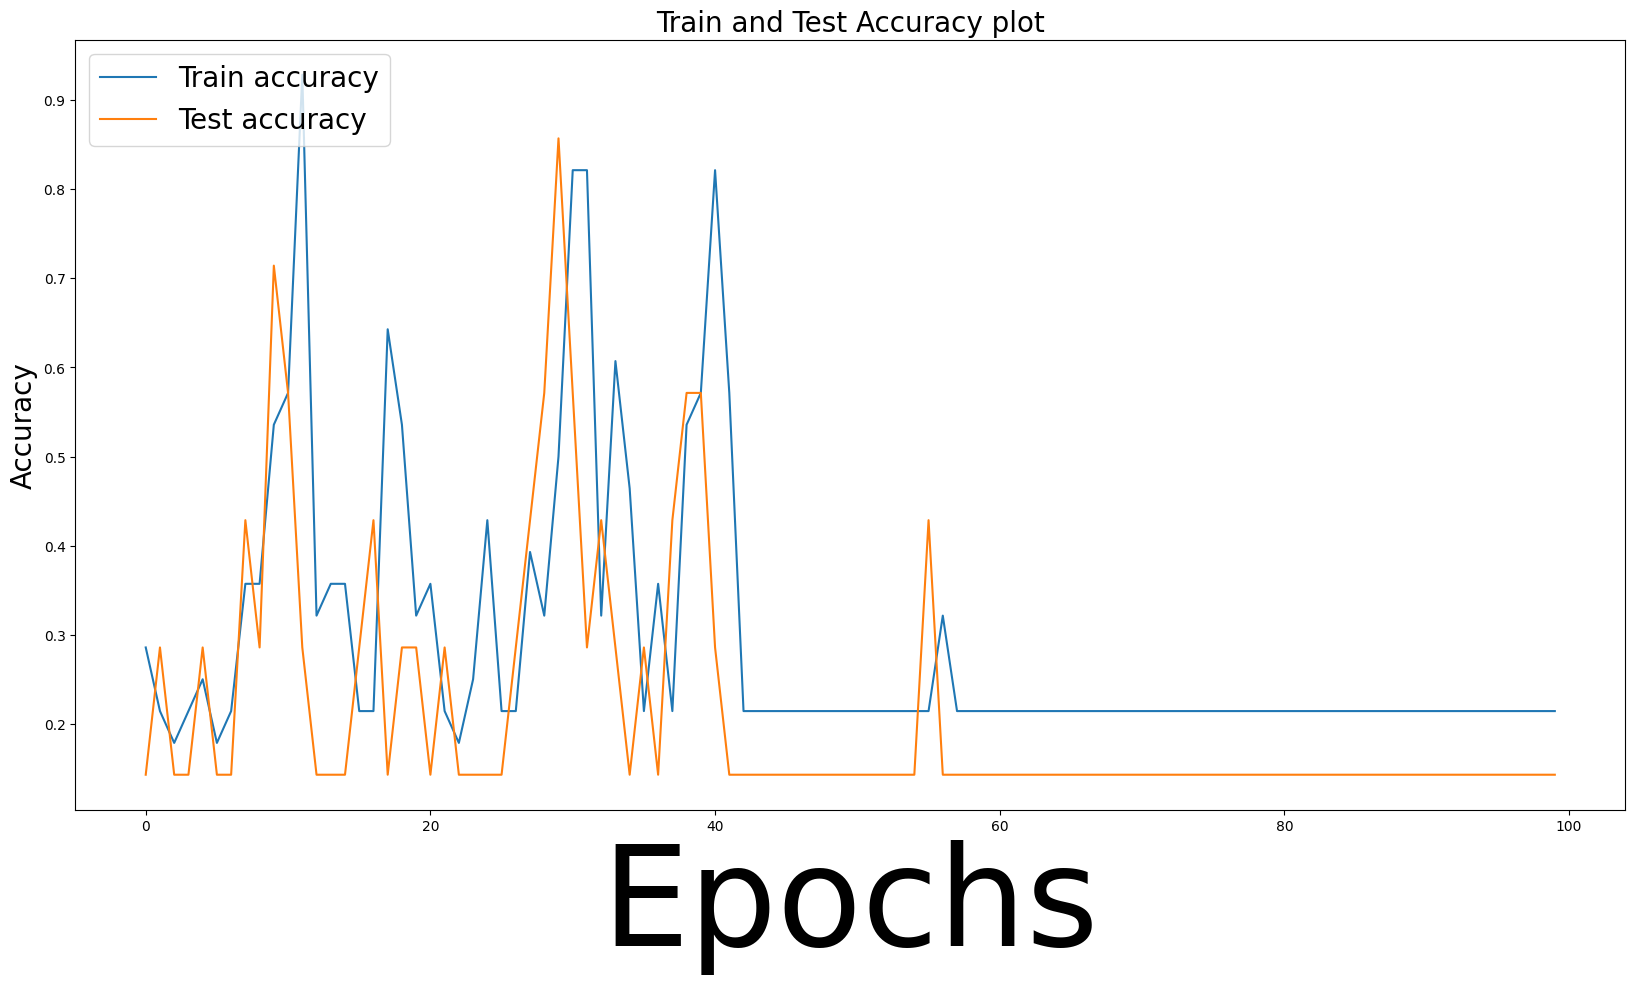

In [ ]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
xc = range(100)

plt.figure(figsize=(20,10))
plt.plot(xc,train_acc,label = 'Train accuracy')
plt.plot(xc,val_acc,label='Test accuracy')
plt.legend(loc='upper left',prop={'size':20})
plt.title('Train and Test Accuracy plot',size=20)
plt.xlabel('Epochs',size=100)
plt.ylabel('Accuracy',size=20)

In [ ]:
model.history.history

{}

In [ ]:
y[16]

array([0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
results = model.evaluate(test_x, test_y)
print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

1/1 [==============================] - 0s 58ms/step - loss: 2.2082 - accuracy: 0.7143
Final test set loss: 2.208190
Final test set accuracy: 0.714286


In [ ]:
len(test_x)

7

In [ ]:
test_y

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
import numpy as np

# Assuming 'single_image_feature' is the feature vector of your single image
single_image_feature = test_x[5]

# Reshape the feature vector to match the expected input shape of the model
single_image_feature = single_image_feature.reshape((1, 6144))

# Get the predicted probabilities for each class
predicted_probabilities = model.predict(single_image_feature)

# The predicted probabilities will be an array of shape (1, 109)
# You can print or analyze these probabilities
print(predicted_probabilities)

predicted_class_index = np.argmax(predicted_probabilities)
print(f"Predicted Class Index: {predicted_class_index}")

1/1 [==============================] - 0s 98ms/step
[[1.6869273e-10 9.9928963e-01 7.0260337e-04 9.4025156e-11 7.7883287e-06]]
Predicted Class Index: 1


In [ ]:
predicted_class_index = np.argmax(predicted_probabilities)
print(f"Predicted Class Index: {predicted_class_index-1}")

Predicted Class Index: 0


**CLASSIFICATION**

In [ ]:
X = new_data
y = flabel

# **K-Nearest Neighbours**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(f2, y, test_size=0.2, random_state=None,stratify = y)

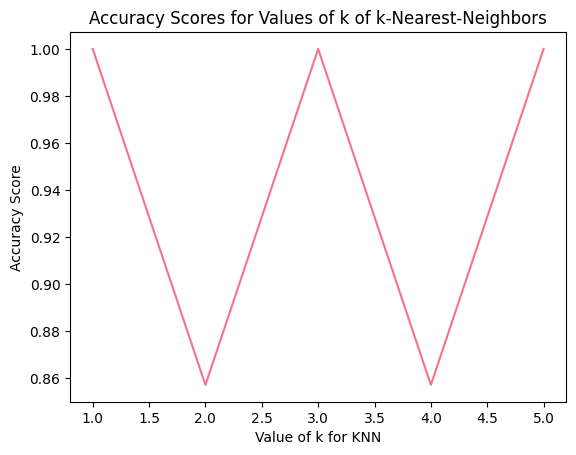

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

k_range = list(range(1,6))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

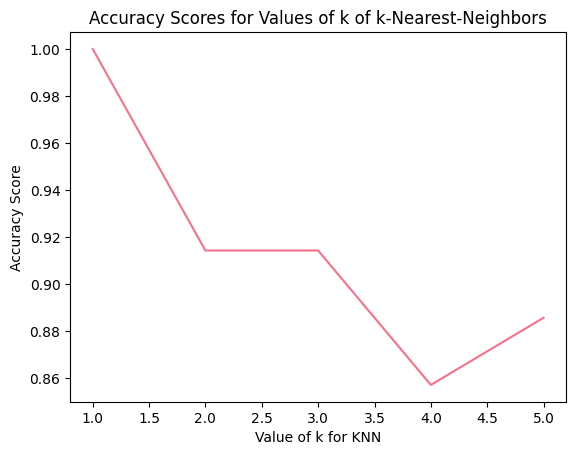

In [ ]:
k_range = list(range(1,6))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(f2, y)
    y_pred = knn.predict(f2)
    scores.append(metrics.accuracy_score(y, y_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

In [ ]:
y

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0.

# **Logistic Regression**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(f2, y, test_size=0.2, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

ValueError: ignored

In [ ]:
len(X_test)

# **Naive bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(X_train,y_train)
y_predict=nb.predict(X_test)
print(metrics.accuracy_score(y_test, y_predict))

ValueError: ignored

## **Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
from sklearn import metrics

# Ensure the number of samples match
#assert x_train.shape[0] == y_train.shape[0], "Inconsistent number of samples between x_train and y_train"
#assert test_x.shape[0] == test_y.shape[0], "Inconsistent number of samples between X_test and y_test"
X_train, X_test, y_train, y_test = train_test_split(f2, y, test_size=0.2, random_state=None,stratify = y)
# Reshape y_train and y_test if necessary
y_train = y_train[:x_train.shape[0]]  # Adjust the size of y_train to match the number of samples in x_train
test_y = test_y[:test_x.shape[0]]     # Adjust the size of y_test to match the number of samples in X_test

# Continue with your SVM model training and evaluation
svm = SVC(kernel="linear", C=0.025, random_state=None)
svm.fit(x_train, y_train)
y_pred = svm.predict(test_x)
print(metrics.accuracy_score(test_y, y_pred))



0.9929577464788732


# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfm=RandomForestClassifier(n_estimators=60,oob_score=True,n_jobs=-1,random_state=None,max_features=None,min_samples_leaf=30)
rfm.fit(X_train,y_train)
y_pred=rfm.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.0


# **Stochastic Gradient Descent**

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd=SGDClassifier(loss="modified_huber",shuffle=False,random_state=None)
sgd.fit(X_train,y_train)
y_pred=sgd.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

ValueError: ignored

# **END**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression()

In [ ]:
clf.fit(X_train, y_train)

ValueError: ignored

In [ ]:
pred = clf.predict(X_test)

In [ ]:
print ('Accuracy from sk-learn: {0}'.format(clf.score(X_test, y_test)))

In [ ]:
from sklearn import preprocessing
import numpy as np
 #X_train = np.array([[ 1., -1.,  2.],
#...                     [ 2.,  0.,  0.],
#...                     [ 0.,  1., -1.]])
X_scaled = preprocessing.scale(X_train)

In [ ]:
X_scaled

In [ ]:
X_train

In [ ]:
X_scaled.std(axis=0)

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_test)

In [ ]:
scaler.mean_

In [ ]:
scaler.scale_

In [ ]:
X_train1 = scaler.transform(X_train)

In [ ]:
X_test1 = scaler.transform(X_test)

In [ ]:
max_abs_scaler = preprocessing.MaxAbsScaler()

In [ ]:
X_train_maxabs = max_abs_scaler.fit_transform(X_train)

In [ ]:
X_test_maxabs = max_abs_scaler.transform(X_test)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_train)
X_test_trans = quantile_transformer.transform(X_test)